In [ ]:
%cd ..

In [ ]:
import tensorflow as tf
import pandas as pd

from src.models.CNN_model import DynamicStampModel
from src.data.stamp_processing import prepare_model_input, get_max_hw,normalize_stamps
from src.data.metadata_processing import process_coordinates, apply_normalization
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_fscore_support
import matplotlib.pyplot as plt
import seaborn as sns
import glob
from sklearn.preprocessing import LabelEncoder
import numpy as np
from sklearn.ensemble import RandomForestClassifier


def eval_step(model, dataset):
    predictions, labels_list = [], []
    for (samples, md), labels in dataset:
        #print(samples.shape)
        logits = model((samples, md), training=False)
        predictions.append(logits)
        labels_list.append(labels)

    predictions = tf.concat(predictions, axis=0)
    labels = tf.concat(labels_list, axis=0)

    precision, recall, f1, _ = precision_recall_fscore_support(
        labels.numpy(), predictions.numpy().argmax(axis=1), average='macro')

    return precision, recall, f1, labels.numpy(), predictions.numpy().argmax(axis=1)

,precision,recall,f1-score,support
AGN,0.00,0.00,0.00,2.00
VS,0.86,0.82,0.84,373.00
asteroid,0.15,1.00,0.27,4.00
bogus,0.92,0.67,0.77,404.00
satellite,0.32,0.65,0.43,34.00
accuracy,0.73,0.73,0.73,0.73
macro avg,0.45,0.63,0.46,817.00
weighted avg,0.86,0.73,0.78,817.00


/home/fandrades/miniconda3/envs/atat2/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/fandrades/miniconda3/envs/atat2/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/fandrades/miniconda3/envs/atat2/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.

,precision,recall,f1-score,support
AGN,0.000000,0.000000,0.000000,2.000000
VS,0.860000,0.922252,0.890039,373.000000
asteroid,0.666667,1.000000,0.800000,4.000000
bogus,0.871314,0.804455,0.836551,404.000000
satellite,0.000000,0.000000,0.000000,34.000000
accuracy,0.823745,0.823745,0.823745,0.823745
macro avg,0.479596,0.545341,0.505318,817.000000
weighted avg,0.826753,0.823745,0.823930,817.000000


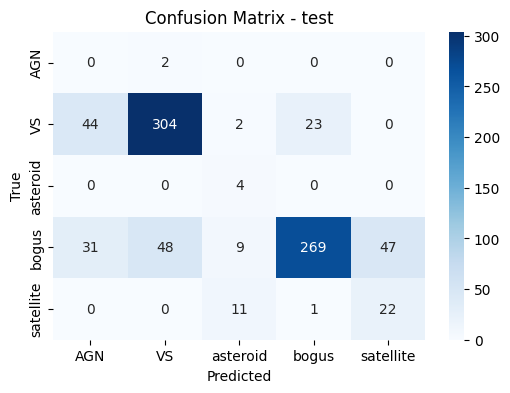

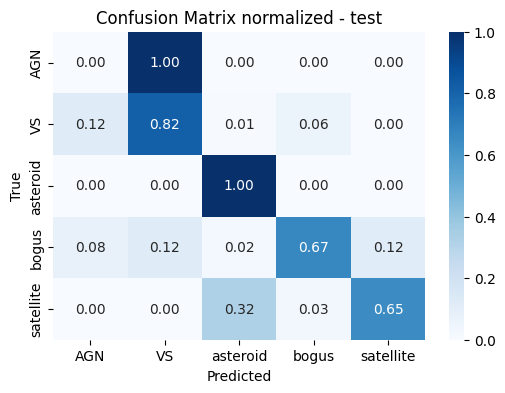

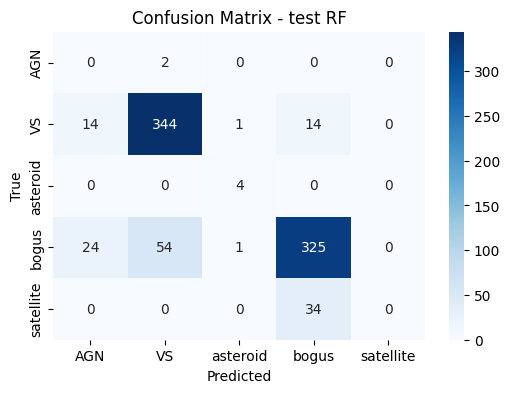

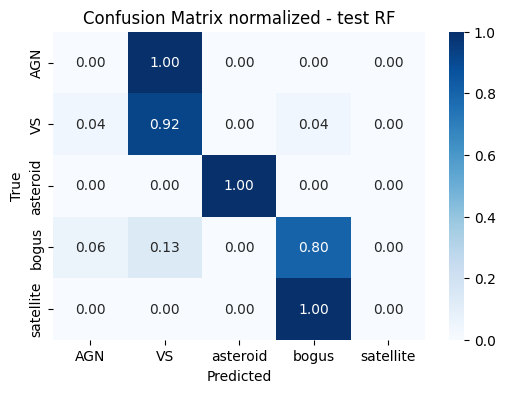

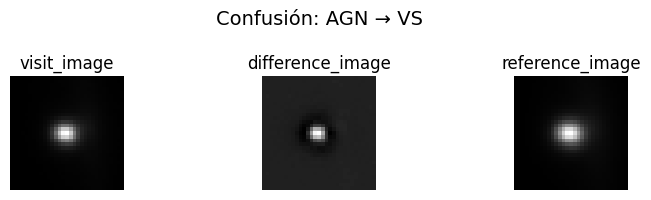

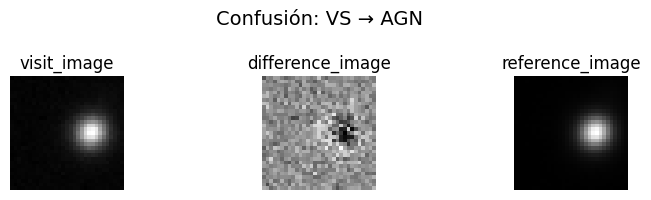

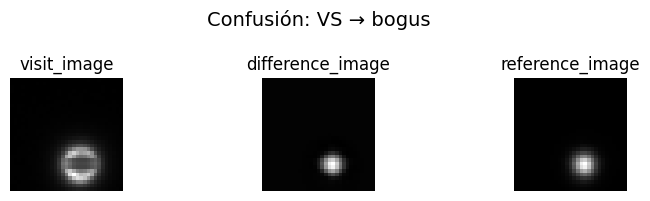

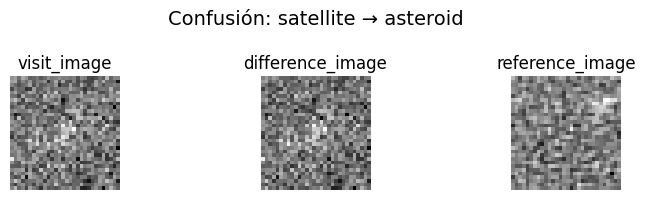

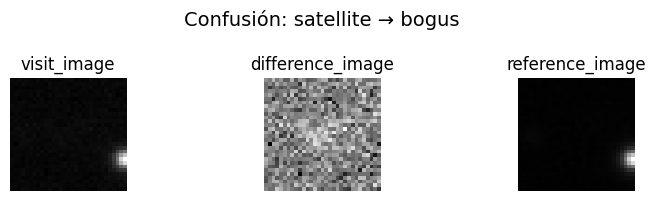

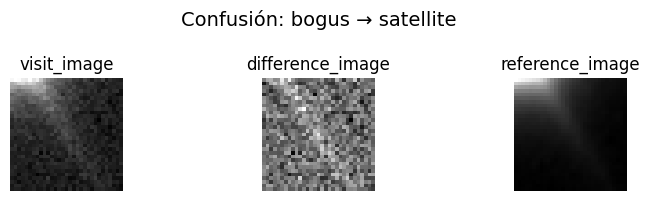

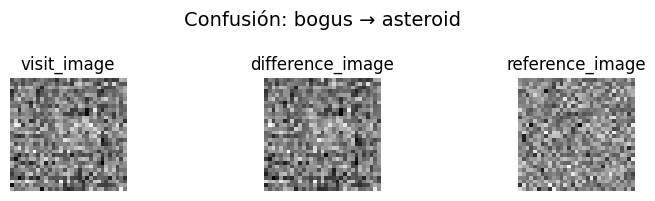

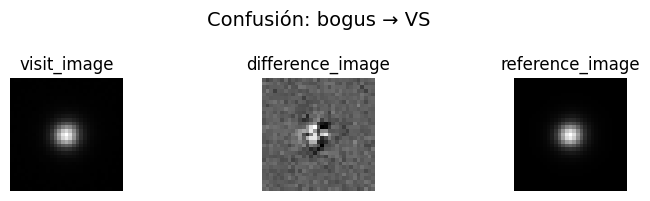

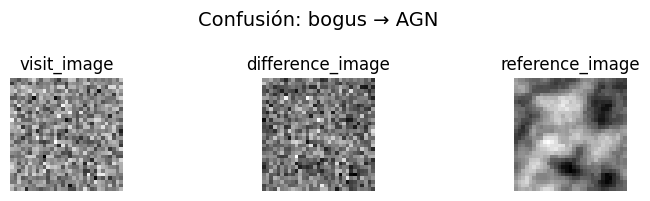

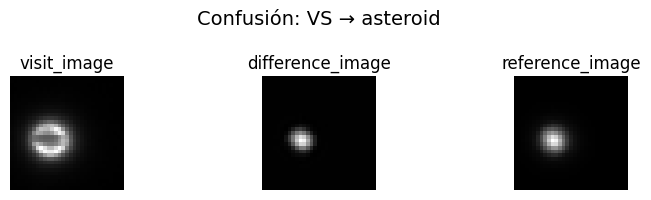

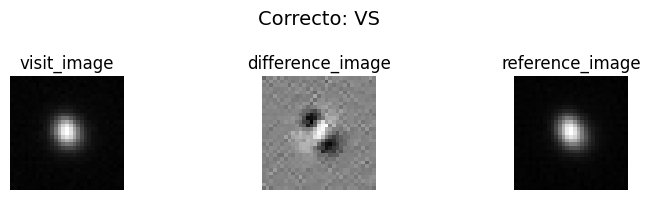

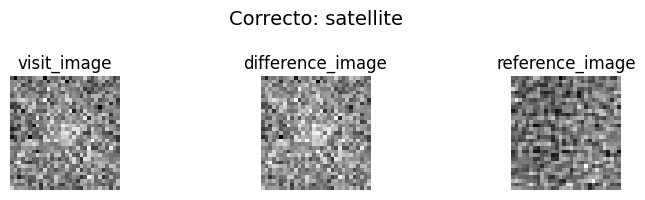

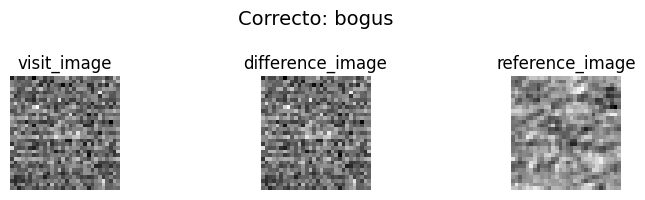

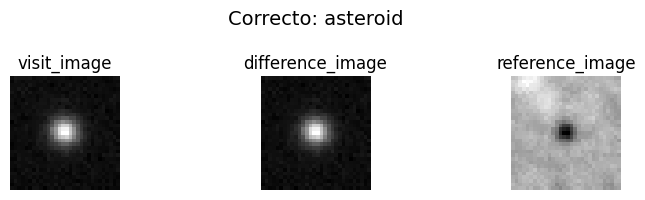

In [ ]:
def process_stamp(data,args):
    stamp_cols = args['stamps_cols']
    stamps = data[stamp_cols].values
    max_h, max_w = get_max_hw(stamps)
    padded_stamps, padding_masks = prepare_model_input(stamps, max_h, max_w)
    padded_stamps = normalize_stamps(padded_stamps, padding_masks)
    return padded_stamps

def process_metadata(
        data, 
        args, 
        dict_info_model, 
        norm_type='z-score', 
        path_norm_dir='./normalization_params', 
        is_test_only=False
        ):
    
    
    columns_to_rm = args['stamps_cols'] + [args['candid_col']] + ["target_name"] # nuevo
    metadata = data.drop(columns=columns_to_rm, axis=1)
    metadata = metadata.set_index(args['id_col'])

    coord_df = process_coordinates(
        oids=metadata.index,
        ra=metadata[args['ra_col']].values,
        dec=metadata[args['dec_col']].values,
        coord_type=args['coord_type'],
    )
    #por ahora estamos botando las coordenadas
    #metadata = pd.concat([metadata, coord_df], axis=1)
    metadata = metadata.drop(columns=[args['ra_col'], args['dec_col']])
    metadata = metadata.fillna(-999)

    ordered_cols = dict_info_model['order_features']
    metadata = metadata[ordered_cols]

    metadata = apply_normalization(
        metadata,
        norm_type=norm_type,
        dict_info_model=dict_info_model,
        path_norm_dir=path_norm_dir,
        is_test_only=is_test_only
    )
    return metadata


def perform_inference(data_path, model_path,zscore_path,path_partition,args,dict_info_model):

    #tengo que leer la data
    #tengo que leer el zscore_path
    #tengo que transformar la data
    #tengo que cargar el modelo
    #dejar la configuracion harcodeada
    #tengo que hacer la prediccion
    #tengo que guardar el resultado
    partition = pd.read_parquet(path_partition)
    oids_train = partition[partition['partition'] == 'training_0'][args['id_col']].tolist()
    oids_test = partition[partition['partition'] == 'test'][args['id_col']].tolist()
    data = []
    path_chunks = glob.glob(f"{data_path}/stamps/*.pkl")
    for path_chunk in path_chunks:
        data.append(pd.read_pickle(path_chunk))
    data = pd.concat(data)

    data_train = data[data[args['id_col']].isin(oids_train)]
    data_test = data[data[args['id_col']].isin(oids_test)]
    y_train = data_train['class'].values
    y_test = data_test['class'].values
    label_encoder = LabelEncoder()
    y_train = label_encoder.fit_transform(y_train)
    y_test = label_encoder.fit_transform(y_test)
    #separar en test, obtener labels
    #print(data.columns)
    stamps = process_stamp(data_test,args)


    md_train = process_metadata(
        data_train, args, dict_info_model,
        norm_type=args['norm_type'], path_norm_dir=zscore_path, 
        is_test_only=False
    )
    md_test = process_metadata(
        data_test, args, dict_info_model,
        norm_type=args['norm_type'], path_norm_dir=zscore_path, 
        is_test_only=True
    )
    #print(md_train.head())

    clf = RandomForestClassifier()
    clf.fit(md_train,y_train)
    preds_test = clf.predict(md_test)

    #print(md_train.isna().sum())
    #print(md_test.isna().sum())

    dataset = tf.data.Dataset.from_tensors(((stamps, md_test),y_test))
    dataset = dataset.unbatch().batch(32).prefetch(5)

    stamp_classifier = tf.keras.models.load_model(
            model_path, custom_objects={"DynamicStampModel": DynamicStampModel})

    _,_,_, y_true_all, y_pred_all = eval_step(stamp_classifier, dataset)

    labels_map = dict_info_model["dict_mapping_classes"]
    target_names = [labels_map[i] for i in sorted(labels_map)]

    # Report
    report = classification_report(y_true_all, y_pred_all, target_names=target_names, output_dict=True)
    report_df = pd.DataFrame(report).transpose()
    display(report_df.round(2))

    report = classification_report(y_true_all, preds_test, target_names=target_names, output_dict=True)
    report_df = pd.DataFrame(report).transpose()
    display(report_df)

    # Confusion Matrix
    cm = confusion_matrix(y_true_all, y_pred_all)
    fig, ax = plt.subplots(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=target_names, yticklabels=target_names, ax=ax)
    ax.set_xlabel("Predicted")
    ax.set_ylabel("True")
    ax.set_title(f"Confusion Matrix - {'test'}")
    plt.show()

    cm = confusion_matrix(y_true_all, y_pred_all,normalize="true")
    fig, ax = plt.subplots(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt=".2f", cmap="Blues", xticklabels=target_names, yticklabels=target_names, ax=ax)
    ax.set_xlabel("Predicted")
    ax.set_ylabel("True")
    ax.set_title(f"Confusion Matrix normalized - {'test'}")
    plt.show()

    cm = confusion_matrix(y_true_all, preds_test)
    fig, ax = plt.subplots(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=target_names, yticklabels=target_names, ax=ax)
    ax.set_xlabel("Predicted")
    ax.set_ylabel("True")
    ax.set_title(f"Confusion Matrix - {'test RF'}")
    plt.show()

    cm = confusion_matrix(y_true_all, preds_test,normalize ="true")
    fig, ax = plt.subplots(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt=".2f", cmap="Blues", xticklabels=target_names, yticklabels=target_names, ax=ax)
    ax.set_xlabel("Predicted")
    ax.set_ylabel("True")
    ax.set_title(f"Confusion Matrix normalized - {'test RF'}")
    plt.show()

    #md_train.hist(figsize=(10, 8))
    #plt.show()
    #display(md_train.describe())

    #get mistakes
    #print(y_true_all)
    #print(target_names)
    #print(y_pred_all)
    """canales = ['visit_image','difference_image','reference_image']
    mismatch_indices = np.where(y_true_all != y_pred_all)[0]
    for indice in mismatch_indices:
        clase_real = target_names[y_true_all[indice]]
        clase_pred = target_names[y_pred_all[indice]]
        #stamp = stamps[indice][:,:,:3]
        fig, axes = plt.subplots(1, 3, figsize=(8, 2))  # 1 fila, 3 columnas

        # Mostrar cada canal en un subplot
        for i in range(3):
            axes[i].imshow(data_test[canales[i]].values[indice], cmap='gray')
            axes[i].axis('off')  # Ocultar ejes
            axes[i].set_title(canales[i])
        
        # Título general
        fig.suptitle(f"{clase_real} vs {clase_pred}", fontsize=14)
        
        plt.tight_layout()
        plt.show()"""
    #import numpy as np
    #import matplotlib.pyplot as plt
    from collections import defaultdict
    
    canales = ['visit_image','difference_image','reference_image']
    N = 1  # Número de ejemplos por tipo de confusión
    
    # Diccionarios para guardar índices
    confusiones = defaultdict(list)
    correctas = defaultdict(list)
    
    # Recorrer todos los ejemplos
    for idx, (y_t, y_p) in enumerate(zip(y_true_all, y_pred_all)):
        if y_t == y_p:
            if len(correctas[y_t]) < N:
                correctas[y_t].append(idx)
        else:
            if len(confusiones[(y_t, y_p)]) < N:
                confusiones[(y_t, y_p)].append(idx)
    
    # Mostrar confusiones
    for (real, pred), indices in confusiones.items():
        for indice in indices:
            clase_real = target_names[real]
            clase_pred = target_names[pred]
    
            fig, axes = plt.subplots(1, 3, figsize=(8, 2))
            for i in range(3):
                axes[i].imshow(data_test[canales[i]].values[indice], cmap='gray')
                axes[i].axis('off')
                axes[i].set_title(canales[i])
            fig.suptitle(f"Confusión: {clase_real} → {clase_pred}", fontsize=14)
            plt.tight_layout()
            plt.show()
    
    # Mostrar clasificaciones correctas
    for clase, indices in correctas.items():
        for indice in indices:
            clase_nombre = target_names[clase]
            fig, axes = plt.subplots(1, 3, figsize=(8, 2))
            for i in range(3):
                axes[i].imshow(data_test[canales[i]].values[indice], cmap='gray')
                axes[i].axis('off')
                axes[i].set_title(canales[i])
            fig.suptitle(f"Correcto: {clase_nombre}", fontsize=14)
            plt.tight_layout()
            plt.show()

    return 

if __name__ == "__main__":
    args = {'stamps_cols': ['visit_image','difference_image','reference_image'], 'candid_col': 'diaSourceId',
             'id_col': 'diaObjectId', 'ra_col': 'ra', 
             'dec_col': 'dec', 'coord_type': 'spherical', 
             'norm_type': 'z-score'}
    
    dict_info_model = {'order_features': ["airmass","magLim","psfFlux","psfFluxErr",
                                          'scienceFlux','scienceFluxErr','seeing','snr'],
                       "dict_mapping_classes":{0: 'AGN', 1: 'VS', 2: 'asteroid', 
                                                        3: 'bogus', 4: 'satellite'}}

    perform_inference(data_path = '../../../../data_acquisition/rubin/data/processed/rubin_5_classes2/ts_stamps_v0.0.3_dp1/',
                      model_path = '../results/ml-runs/908301692482344949/bbcc606b8b5945e4a6f80a256fb0a8c8/artifacts/model.keras',
                      zscore_path= '../results/ml-runs/908301692482344949/bbcc606b8b5945e4a6f80a256fb0a8c8/artifacts/',
                      path_partition='../../../../data_acquisition/rubin/data/processed/partitions/rubin_5_classes_Rubin_SV_095_-25/partitions.parquet',
                      args=args, dict_info_model=dict_info_model) 